In [2]:
import os
import pandas as pd
import re
import numpy as np
import mne
from mne.io import read_raw_edf
from mne.filter import filter_data
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import PyQt5

from scipy.signal import butter, filtfilt,savgol_filter,find_peaks,welch
from scipy.ndimage import median_filter
from scipy.ndimage import gaussian_filter

from scipy.stats import kurtosis
from sklearn.preprocessing import normalize



Using matplotlib as 2D backend.
Using data from preloaded Raw for 1 events and 7501 original time points ...
Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


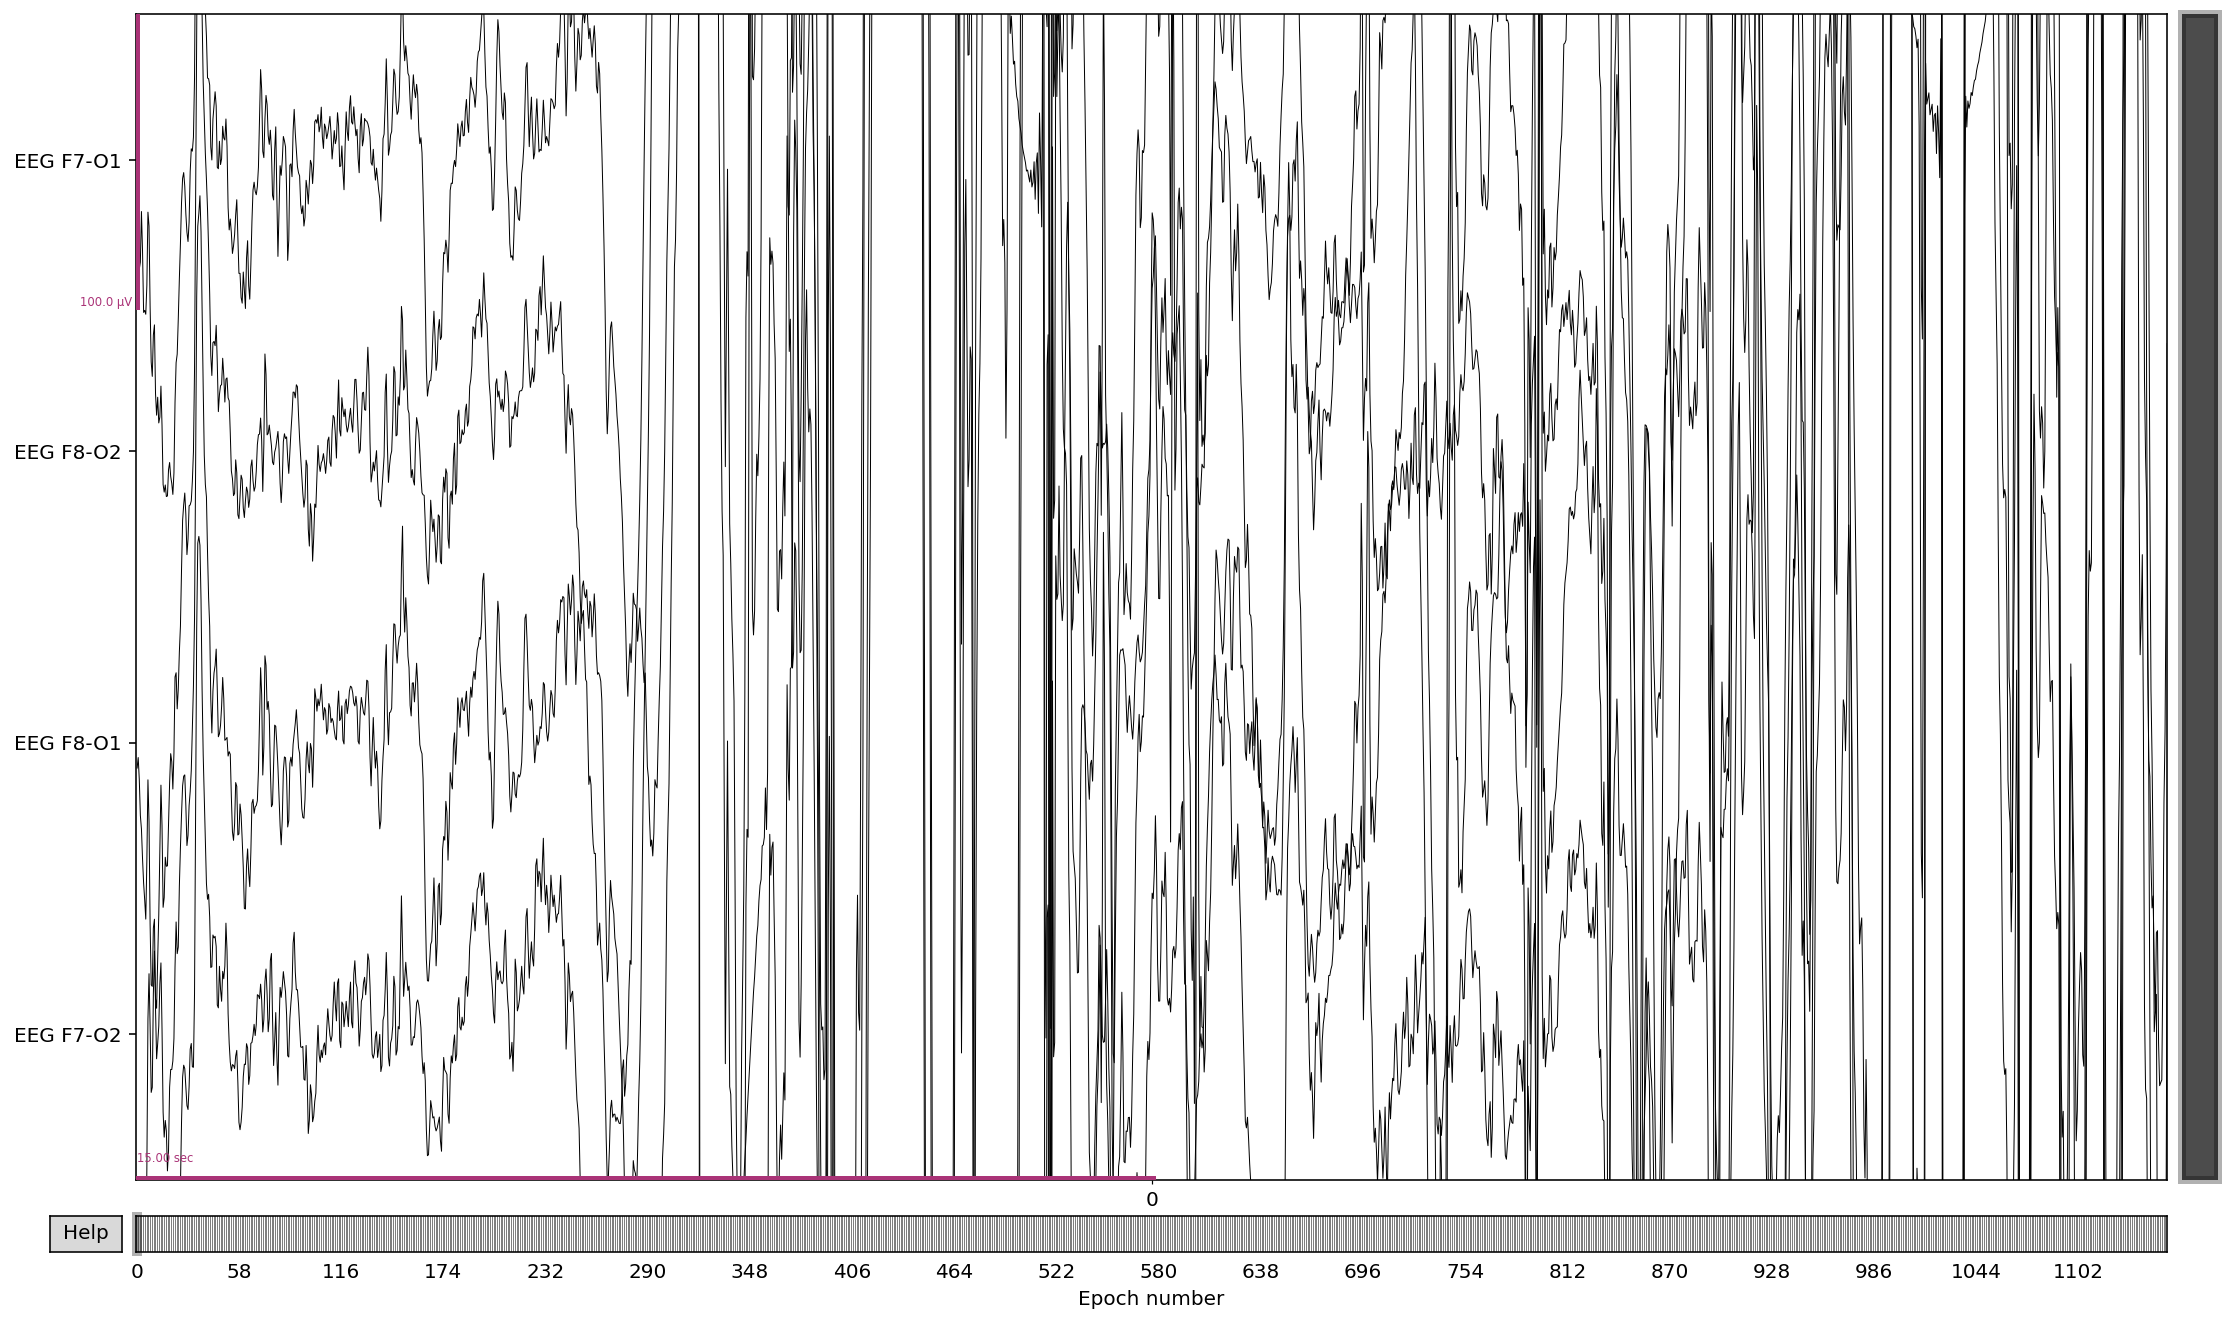

In [12]:
# Scroll through channels
plt.switch_backend('QtAgg')

plt.ion()

epochs_sc_0.plot(n_epochs=1, scalings={'eeg':0.00005}, 
                 show=True, block=True)


In [32]:
plt.ioff()

fig, ax = plt.subplots(figsize=(10, 6));

ax.plot(smA2,label='Alpha', color='coral')

ax.plot(-powerAlphaAUC,label='Alpha',color='coral')
#ax.plot(smT2,label='Theta')

#ax.plot(sum_Alpha,label='Alpha sum',color='teal')
#ax.plot(smA1,label='Alpha sum',color='teal')

#ax.plot(smT2,label='Theta')
#ax.plot(smD2,label ='delta')
#ax.plot(AT_ratio,label ='ratio')

#ax.plot((smA2)-(smT2),label ='ratio')

#plt.plot(ind_max_delta,max_delta_smoothed[ind_max_delta], 'r*', markersize=10)
plt.xlabel('Time')
plt.xlabel('Epochs')
plt.ylabel('Smoothed Max Delta')
plt.title('Smoothed Max Delta Plot')
ax.legend(fontsize = 10)

plt.show()

In [ ]:
epochs_sc_1

In [3]:

# Set the directory path
main_path = '/Users/mhacohen/Desktop/Sleepstudy/subjects/control/Dreem/algo/Sachin'
os.chdir(main_path)

# Set directory path to where the EDF files are located
edf_dir = main_path

# Get list of EDF files in the directory
edf_files = [file for file in os.listdir(edf_dir) if file.endswith('.edf')]
csv_files = [file for file in os.listdir(edf_dir) if (file.endswith(r'.csv') and not (file.endswith(r'fft.csv')))]
csv_files.remove('sleep_stats_sc.csv')
EEG = mne.io.read_raw_edf(edf_files[0], preload=True)

#raw.set_eeg_reference('average', projection=True)

winlen = EEG.info['sfreq'] * 4
overlap = EEG.info['sfreq'] * 2

hzL = np.linspace(0, EEG.info['sfreq'] / 2, int(winlen / 2) + 1)  # frequencies for every window

channels = ['EEG F7-O1', 'EEG F8-O2','EEG F8-O1', 'EEG F7-O2']

# Select channels

delta = [0.75, 4]
theta = [4, 8]
alpha = [8, 12]
beta = [13, 20]
allfreq = [1, 20]
deltaidx = np.searchsorted(hzL, delta)
thetaidx = np.searchsorted(hzL, theta)
alphaidx = np.searchsorted(hzL, alpha)
betaidx = np.searchsorted(hzL, beta)
allfreqidx = np.searchsorted(hzL, allfreq)

sleep_stats = []


Extracting EDF parameters from /Users/mhacohen/Desktop/Sleepstudy/subjects/control/Dreem/algo/Sachin/sfsleeproject_test16@dreemtrial.com_2023-05-23T22-47-57[04-00].edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8651249  =      0.000 ... 34604.996 secs...


In [4]:
# Loop through each EDF file run filter and save staging 
for edf_file,i in zip(edf_files,range(len(edf_files))):
    # Extract date information from the file name using regular expressions
    file_date = re.search(r'\d{4}-\d{2}-\d{2}', edf_file).group()
    file_date = datetime.strptime(file_date, '%Y-%m-%d').date()

    # Extract time from the time string
    file_time = re.search(r'\d{2}-\d{2}-\d{2}\[\d{2}-\d{2}\]', edf_file).group()
    file_time = file_time[:8]
    file_time = datetime.strptime(file_time, '%H-%M-%S').time()

    # Check if the time is greater than 19:00:00
    if file_time > datetime.strptime('19:00:00', '%H:%M:%S').time():
        file_date += timedelta(days=1)  # Add one day

    print(f"EDF file {edf_file} was recorded on {file_date.strftime('%Y-%m-%d')}")

    # Load EDF file using MNE
    edf_path = os.path.join(edf_dir, edf_file)
    EEG = mne.io.read_raw_edf(edf_path, preload=True)
    
    EEG.pick_channels(channels)

    # Filter the data
    EEG.filter(l_freq=0.75, h_freq=20, picks=channels)

    # Epoch the data into 30-second windows
    events = mne.make_fixed_length_events(EEG, start=0, duration=30)

    # Epoch the EEG data
    epochs = mne.Epochs(EEG, events, tmin=0, tmax=30, baseline=None)
    
    # Load stage file
    stagefile = f"dreem_sc_{file_date.strftime('%Y_%m_%d')}.csv"
    stage_path = os.path.join(edf_dir, stagefile)
    stages = pd.read_csv(stage_path)
    
    onset_timedeltas = pd.to_timedelta(stages['Time [hh:mm:ss]'])
    onset_seconds = onset_timedeltas.dt.total_seconds()

    # Convert stages dataframe to MNE annotations
    annotations = mne.Annotations(onset=onset_seconds,
                                 duration=stages['Duration[s]'].values,
                                 description=stages['Sleep Stage'].values)
    # Add annotations to the epochs
    EEG.set_annotations(annotations)
    #EEG = np.transpose(EEG, (1, 2, 0))
    # Save the processed data to a file or perform further analysis
    EEG.save(f'processed_data_{i}.fif',overwrite=True)

    # After the relevant code block where the variables are defined

    # Create a dictionary to hold the variable names and values
    data_dict = {}

    # Add variables to the dictionary with dynamic names
    data_dict[f'EEG_sc_{i}'] = epochs.get_data() 
     
    data_dict[f'stages_sc_{i}'] = stages
    data_dict[f'date_sc_{i}'] = file_date
    data_dict[f'epochs_sc_{i}'] = epochs
    # Add variables to the workspace
    globals().update(data_dict)


EDF file sfsleeproject_test16@dreemtrial.com_2023-05-23T22-47-57[04-00].edf was recorded on 2023-05-24
Extracting EDF parameters from /Users/mhacohen/Desktop/Sleepstudy/subjects/control/Dreem/algo/Sachin/sfsleeproject_test16@dreemtrial.com_2023-05-23T22-47-57[04-00].edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8651249  =      0.000 ... 34604.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.75 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.75
- Lower transition bandwidth: 0.75 Hz (-6 dB cutoff frequency: 0.38 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1101 samples (4.404 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s


Not setting metadata
1153 matching events found
No baseline correction applied
0 projection items activated
Overwriting existing file.
Writing /Users/mhacohen/Desktop/Sleepstudy/subjects/control/Dreem/algo/Sachin/processed_data_0.fif


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s finished
/var/folders/nj/k6wpp3gn72x04wh_yy2nwr600000gr/T/ipykernel_29485/4069739352.py:46: RuntimeWarning: Omitted 145 annotation(s) that were outside data range.
  EEG.set_annotations(annotations)
/var/folders/nj/k6wpp3gn72x04wh_yy2nwr600000gr/T/ipykernel_29485/4069739352.py:49: RuntimeWarning: This filename (/Users/mhacohen/Desktop/Sleepstudy/subjects/control/Dreem/algo/Sachin/processed_data_0.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  EEG.save(f'processed_data_{i}.fif',overwrite=True)


Closing /Users/mhacohen/Desktop/Sleepstudy/subjects/control/Dreem/algo/Sachin/processed_data_0.fif
[done]
Using data from preloaded Raw for 1153 events and 7501 original time points ...
0 bad epochs dropped
EDF file sfsleeproject_test16@dreemtrial.com_2023-05-28T23-10-08[04-00].edf was recorded on 2023-05-29
Extracting EDF parameters from /Users/mhacohen/Desktop/Sleepstudy/subjects/control/Dreem/algo/Sachin/sfsleeproject_test16@dreemtrial.com_2023-05-28T23-10-08[04-00].edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8572999  =      0.000 ... 34291.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.75 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.75
- Lower transition bandwidth: 0.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s


Not setting metadata
1143 matching events found
No baseline correction applied
0 projection items activated
Overwriting existing file.
Writing /Users/mhacohen/Desktop/Sleepstudy/subjects/control/Dreem/algo/Sachin/processed_data_1.fif


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
/var/folders/nj/k6wpp3gn72x04wh_yy2nwr600000gr/T/ipykernel_29485/4069739352.py:46: RuntimeWarning: Omitted 100 annotation(s) that were outside data range.
  EEG.set_annotations(annotations)
/var/folders/nj/k6wpp3gn72x04wh_yy2nwr600000gr/T/ipykernel_29485/4069739352.py:49: RuntimeWarning: This filename (/Users/mhacohen/Desktop/Sleepstudy/subjects/control/Dreem/algo/Sachin/processed_data_1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  EEG.save(f'processed_data_{i}.fif',overwrite=True)


Closing /Users/mhacohen/Desktop/Sleepstudy/subjects/control/Dreem/algo/Sachin/processed_data_1.fif
[done]
Using data from preloaded Raw for 1143 events and 7501 original time points ...
0 bad epochs dropped
EDF file sfsleeproject_test16@dreemtrial.com_2023-05-23T00-59-47[04-00].edf was recorded on 2023-05-23
Extracting EDF parameters from /Users/mhacohen/Desktop/Sleepstudy/subjects/control/Dreem/algo/Sachin/sfsleeproject_test16@dreemtrial.com_2023-05-23T00-59-47[04-00].edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6467499  =      0.000 ... 25869.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.75 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.75
- Lower transition bandwidth: 0.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


Not setting metadata
862 matching events found
No baseline correction applied
0 projection items activated
Overwriting existing file.
Writing /Users/mhacohen/Desktop/Sleepstudy/subjects/control/Dreem/algo/Sachin/processed_data_2.fif


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s finished
/var/folders/nj/k6wpp3gn72x04wh_yy2nwr600000gr/T/ipykernel_29485/4069739352.py:46: RuntimeWarning: Omitted 119 annotation(s) that were outside data range.
  EEG.set_annotations(annotations)
/var/folders/nj/k6wpp3gn72x04wh_yy2nwr600000gr/T/ipykernel_29485/4069739352.py:46: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  EEG.set_annotations(annotations)
/var/folders/nj/k6wpp3gn72x04wh_yy2nwr600000gr/T/ipykernel_29485/4069739352.py:49: RuntimeWarning: This filename (/Users/mhacohen/Desktop/Sleepstudy/subjects/control/Dreem/algo/Sachin/processed_data_2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw

Closing /Users/mhacohen/Desktop/Sleepstudy/subjects/control/Dreem/algo/Sachin/processed_data_2.fif
[done]
Using data from preloaded Raw for 862 events and 7501 original time points ...
0 bad epochs dropped
EDF file sfsleeproject_test16@dreemtrial.com_2023-04-27T01-12-24[04-00].edf was recorded on 2023-04-27
Extracting EDF parameters from /Users/mhacohen/Desktop/Sleepstudy/subjects/control/Dreem/algo/Sachin/sfsleeproject_test16@dreemtrial.com_2023-04-27T01-12-24[04-00].edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5045749  =      0.000 ... 20182.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.75 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.75
- Lower transition bandwidth: 0.7

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s


Not setting metadata
672 matching events found
No baseline correction applied
0 projection items activated
Overwriting existing file.
Writing /Users/mhacohen/Desktop/Sleepstudy/subjects/control/Dreem/algo/Sachin/processed_data_3.fif


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s finished
/var/folders/nj/k6wpp3gn72x04wh_yy2nwr600000gr/T/ipykernel_29485/4069739352.py:46: RuntimeWarning: Omitted 144 annotation(s) that were outside data range.
  EEG.set_annotations(annotations)
/var/folders/nj/k6wpp3gn72x04wh_yy2nwr600000gr/T/ipykernel_29485/4069739352.py:46: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  EEG.set_annotations(annotations)
/var/folders/nj/k6wpp3gn72x04wh_yy2nwr600000gr/T/ipykernel_29485/4069739352.py:49: RuntimeWarning: This filename (/Users/mhacohen/Desktop/Sleepstudy/subjects/control/Dreem/algo/Sachin/processed_data_3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  EEG.save(f'processed_da

Closing /Users/mhacohen/Desktop/Sleepstudy/subjects/control/Dreem/algo/Sachin/processed_data_3.fif
[done]
Using data from preloaded Raw for 672 events and 7501 original time points ...
0 bad epochs dropped
EDF file sfsleeproject_test16@dreemtrial.com_2023-05-14T22-38-29[04-00].edf was recorded on 2023-05-15
Extracting EDF parameters from /Users/mhacohen/Desktop/Sleepstudy/subjects/control/Dreem/algo/Sachin/sfsleeproject_test16@dreemtrial.com_2023-05-14T22-38-29[04-00].edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8499499  =      0.000 ... 33997.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.75 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.75
- Lower transition bandwidth: 0.7

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s


Not setting metadata
1133 matching events found
No baseline correction applied
0 projection items activated
Overwriting existing file.
Writing /Users/mhacohen/Desktop/Sleepstudy/subjects/control/Dreem/algo/Sachin/processed_data_4.fif


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
/var/folders/nj/k6wpp3gn72x04wh_yy2nwr600000gr/T/ipykernel_29485/4069739352.py:46: RuntimeWarning: Omitted 164 annotation(s) that were outside data range.
  EEG.set_annotations(annotations)
/var/folders/nj/k6wpp3gn72x04wh_yy2nwr600000gr/T/ipykernel_29485/4069739352.py:49: RuntimeWarning: This filename (/Users/mhacohen/Desktop/Sleepstudy/subjects/control/Dreem/algo/Sachin/processed_data_4.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  EEG.save(f'processed_data_{i}.fif',overwrite=True)


Closing /Users/mhacohen/Desktop/Sleepstudy/subjects/control/Dreem/algo/Sachin/processed_data_4.fif
[done]
Using data from preloaded Raw for 1133 events and 7501 original time points ...
0 bad epochs dropped
EDF file sfsleeproject_test16@dreemtrial.com_2023-05-07T22-48-23[04-00].edf was recorded on 2023-05-08
Extracting EDF parameters from /Users/mhacohen/Desktop/Sleepstudy/subjects/control/Dreem/algo/Sachin/sfsleeproject_test16@dreemtrial.com_2023-05-07T22-48-23[04-00].edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8355499  =      0.000 ... 33421.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.75 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.75
- Lower transition bandwidth: 0.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s


Not setting metadata
1114 matching events found
No baseline correction applied
0 projection items activated
Overwriting existing file.
Writing /Users/mhacohen/Desktop/Sleepstudy/subjects/control/Dreem/algo/Sachin/processed_data_5.fif


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
/var/folders/nj/k6wpp3gn72x04wh_yy2nwr600000gr/T/ipykernel_29485/4069739352.py:46: RuntimeWarning: Omitted 144 annotation(s) that were outside data range.
  EEG.set_annotations(annotations)
/var/folders/nj/k6wpp3gn72x04wh_yy2nwr600000gr/T/ipykernel_29485/4069739352.py:49: RuntimeWarning: This filename (/Users/mhacohen/Desktop/Sleepstudy/subjects/control/Dreem/algo/Sachin/processed_data_5.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  EEG.save(f'processed_data_{i}.fif',overwrite=True)


Closing /Users/mhacohen/Desktop/Sleepstudy/subjects/control/Dreem/algo/Sachin/processed_data_5.fif
[done]
Using data from preloaded Raw for 1114 events and 7501 original time points ...
0 bad epochs dropped
EDF file sfsleeproject_test16@dreemtrial.com_2023-05-24T23-35-04[04-00].edf was recorded on 2023-05-25
Extracting EDF parameters from /Users/mhacohen/Desktop/Sleepstudy/subjects/control/Dreem/algo/Sachin/sfsleeproject_test16@dreemtrial.com_2023-05-24T23-35-04[04-00].edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7688749  =      0.000 ... 30754.996 secs...


KeyboardInterrupt: 

In [5]:
#Flag noisy epochs

for i in range(len(edf_files)):
    print(i)
    data = globals()[f'EEG_sc_{i}']
    stages = globals()[f'stages_sc_{i}']
    date = globals()[f'date_sc_{i}']
    epochs = globals()[f'epochs_sc_{i}']
    
    sd_crt = 2

    var_epoch_all = np.var(data, axis=2)  # variance
    kurt_epoch_all = kurtosis(data, axis=2)  # kurtosis
    mobility_epoch_all = np.sqrt(np.var(np.diff(data, axis=2), axis=2)) / (var_epoch_all)
    complexity_epoch_all = np.sqrt(np.var(np.diff(np.diff(data, axis=2), axis=2), axis=2)) / np.var(np.diff(data, axis=2), axis=2)
    max_amp = np.max(np.abs(data), axis=2)
    diff_all = np.median(np.diff(data, axis=2), axis=2)

    # initilize the fft dataset in same size of data but only until nyquist
    fftWelch = np.zeros((data.shape[0],data.shape[1],len(hzL)))

    for eleci in range(data.shape[1]):
        hzL = np.linspace(0, EEG.info['sfreq'] / 2, int(np.floor(winlen / 2) + 1))

        for epochi in range(data.shape[0]):
            epochData = data[epochi,eleci,:]
            numFrames = int((len(epochData) - winlen) / overlap) + 1
            fftA = np.zeros(len(hzL))

            for j in range(numFrames):
                frameData = epochData[int(j * overlap) :int( j * overlap + winlen)]
                fftTemp = np.fft.fft(np.hamming(winlen) * frameData) / winlen
                fftA += 2 * np.abs(fftTemp[:len(hzL)])

            fftWelch[epochi,eleci :] = fftA / numFrames
    #
    #sum up frequancies in 10 to 20 hz
    Nfreqs = [10, 20]
    freqsidx = np.searchsorted(hzL, Nfreqs)
    fftWelch_all = np.squeeze(np.sum(fftWelch[:, :,freqsidx[0]:freqsidx[-1] + 1],axis=2))

    # get stds and medians 

    median_var_all = np.median(var_epoch_all,axis = 0);
    sd_var_all = np.std(var_epoch_all,axis = 0);
    
    median_kurt_all = np.median(kurt_epoch_all,axis = 0);
    sd_kurt_all = np.std(kurt_epoch_all,axis=0);
    
    median_fft_all = np.median(fftWelch_all, axis = 0);
    sd_fft_all = np.std(fftWelch_all, axis = 0);
    
    median_amp_all = np.median(max_amp, axis=0);
    sd_amp_all = np.std(max_amp, axis=0);
    
    median_mob_all = np.median(mobility_epoch_all, axis=0);
    sd_mob_all = np.std(mobility_epoch_all, axis=0);
    
    median_comp_all = np.median(complexity_epoch_all, axis=0);
    sd_comp_all = np.std(complexity_epoch_all, axis=0);
    
    median_diff_all = np.median(diff_all, axis=0);
    std_diff_all = np.std(diff_all,axis=0);
    
    #initilize empty datasets
    fft_mark_all = np.zeros((data.shape[0], data.shape[1]))
    kurt_mark_all = np.zeros((data.shape[0], data.shape[1]))
    var_mark_all = np.zeros((data.shape[0], data.shape[1]))
    mob_mark_all = np.zeros((data.shape[0], data.shape[1]))
    comp_mark_all = np.zeros((data.shape[0], data.shape[1]))
    amp_mark_all = np.zeros((data.shape[0], data.shape[1]))
    diff_mark_all = np.zeros((data.shape[0], data.shape[1]))
    maxk_amp_all = np.zeros((data.shape[0], data.shape[1]))        
    
    for eleci in range(median_var_all.shape[0]):
        fft_mark_all[:, eleci] = np.where(fftWelch_all[:,eleci] > sd_crt * sd_fft_all[eleci] + median_fft_all[eleci], 1, 0)
        kurt_mark_all[:, eleci] = np.where(kurt_epoch_all[:,eleci] > sd_crt * sd_kurt_all[eleci] + median_kurt_all[eleci], 1, 0)
        var_mark_all[:, eleci] = np.where(var_epoch_all[:,eleci] > sd_crt * sd_var_all[eleci] + median_var_all[eleci], 1, 0)
        mob_mark_all[:, eleci] = np.where(mobility_epoch_all[:,eleci] > sd_crt * sd_mob_all[eleci] + median_mob_all[eleci], 1, 0)
        comp_mark_all[:, eleci] = np.where(complexity_epoch_all[:,eleci] > sd_crt * sd_comp_all[eleci] + median_comp_all[eleci], 1, 0)
        amp_mark_all[:, eleci] = np.where(max_amp[:,eleci] > sd_crt * sd_amp_all[eleci] + median_amp_all[eleci], 1, 0)
        diff_mark_all[:, eleci] = np.where(diff_all[:,eleci] > sd_crt * std_diff_all[eleci] + median_diff_all[eleci], 1, 0)
           
        abs_data = np.abs(data)
        indices = np.argsort(abs_data, axis=2)[:, eleci, -10:]
        amp_threshold = 200
        min_amp_count = 10

        for epochi in range(abs_data.shape[0]):
            amp_exceed_count = np.sum(abs_data[epochi, eleci, indices[epochi, :]] > amp_threshold)
            maxk_amp_all[epochi, eleci] = np.where(amp_exceed_count >= min_amp_count, 1, 0)

        # Update fftClean variable in the workspace

        # Concatenate all the arrays
        mark_all = np.concatenate((fft_mark_all[:, :, np.newaxis], kurt_mark_all[:, :, np.newaxis],
                                   var_mark_all[:, :, np.newaxis], mob_mark_all[:, :, np.newaxis],
                                   comp_mark_all[:, :, np.newaxis], amp_mark_all[:, :, np.newaxis],
                                   diff_mark_all[:, :, np.newaxis]),  axis=2) 

        # Find nonzero elements per electrode
        mark_all_by_elec = np.any(mark_all, axis=2)

        # Sum ones
        mark_all_by_elec_sum = np.sum(mark_all_by_elec, axis=0)

        # Find electrode with minimum ones
        good_elec_ind = np.argmin(mark_all_by_elec_sum)

        # Create final_mark as a binary vector
        final_mark = mark_all_by_elec[:,good_elec_ind]

        epochs.reject = np.logical_not(~final_mark)

        rejected_epochs = epochs.reject

        # Print the indices of rejected epochs
        rejected_indices = np.where(rejected_epochs)[0]
        globals()[f'epochs_sc_{i}'] = epochs

        fftClean = np.copy(fftWelch)
        fftClean[epochs.reject,good_elec_ind] = np.nan
        fftClean = fftClean[:,good_elec_ind]
        globals()[ f'fft_sc_{i+1}'] = fftClean
        globals()[ f'gelect_sc_{i+1}'] = good_elec_ind

0
1
2
3
4


KeyboardInterrupt: 

In [86]:
np.sum(fftClean[:,deltaidx[0]:deltaidx[1]],1).shape

(862,)

In [31]:
# Sleep/ Wake detection


i = 1
fftClean = eval('fft_sc_' + str(i))
stages = eval('stages_sc_' + str(i))
date = eval('date_sc_' + str(i))
good_elec_ind = eval('gelect_sc_' + str(i))
print(i)

delta = [0.75, 4]
theta = [4, 8]
alpha = [8, 12]
beta = [12, 20]
allfreq = [0.75, 20]

deltaidx = np.searchsorted(hzL, delta)
thetaidx = np.searchsorted(hzL, theta)
alphaidx = np.searchsorted(hzL, alpha)
betaidx = np.searchsorted(hzL, beta)
allfreqidx = np.searchsorted(hzL, allfreq)

powerTot = np.sum(fftClean[:, allfreqidx[0]:allfreqidx[1]], axis=1)

powerAlphaAUC = np.array([np.trapz(fftClean[x, alphaidx[0]:alphaidx[1]], hzL[alphaidx[0]:alphaidx[1]]) for x in range(fftClean.shape[0])])
powerThetaAUC = np.array([np.trapz(hzL[thetaidx[0]:thetaidx[1]], fftClean[x, thetaidx[0]:thetaidx[1]]) for x in range(fftClean.shape[0])])
powerDeltaAUC = np.array([np.trapz(hzL[deltaidx[0]:deltaidx[1]], fftClean[x, deltaidx[0]:deltaidx[1]]) for x in range(fftClean.shape[0])])

sum_Alpha = np.sum((fftClean[:, alphaidx[0]:alphaidx[1]]),1)
sum_Theta = np.sum((fftClean[:, thetaidx[0]:thetaidx[1]]),1)
sum_Delta = np.sum((fftClean[:, deltaidx[0]:deltaidx[1]]),1)

# Replace NaN values with interpolation for Alpha and Theta, sum of Amp's and AUC's.
# Alpha AUC interpolation 
nan_indices_alpha = np.isnan(powerAlphaAUC)
powerAlphaAUC[nan_indices_alpha] = np.interp(np.flatnonzero(nan_indices_alpha), np.flatnonzero(~nan_indices_alpha), powerAlphaAUC[~nan_indices_alpha])
# Alpha Amps
nan_indices_alpha = np.isnan(sum_Alpha)
sum_Alpha[nan_indices_alpha] = np.interp(np.flatnonzero(nan_indices_alpha), np.flatnonzero(~nan_indices_alpha), sum_Alpha[~nan_indices_alpha])
# Theta AUC interpolation 

nan_indices_theta = np.isnan(powerThetaAUC)
powerThetaAUC[nan_indices_theta] = np.interp(np.flatnonzero(nan_indices_theta), np.flatnonzero(~nan_indices_theta), powerThetaAUC[~nan_indices_theta])
# Theta Amps
nan_indices_theta = np.isnan(sum_Theta)
sum_Theta[nan_indices_theta] = np.interp(np.flatnonzero(nan_indices_theta), np.flatnonzero(~nan_indices_theta), sum_Theta[~nan_indices_theta])
# Delta AUC interpolation 
nan_indices_delta = np.isnan(powerDeltaAUC)
powerDeltaAUC[nan_indices_delta] = np.interp(np.flatnonzero(nan_indices_delta), np.flatnonzero(~nan_indices_delta), powerDeltaAUC[~nan_indices_delta])
# Delta Amps
nan_indices_delta = np.isnan(sum_Delta)
sum_Delta[nan_indices_delta] = np.interp(np.flatnonzero(nan_indices_delta), np.flatnonzero(~nan_indices_delta), sum_Delta[~nan_indices_delta])

smA1 = gaussian_filter(sum_Alpha, sigma=10, mode='wrap')
smT1 = gaussian_filter(sum_Theta, sigma=10, mode='wrap')
smD1 = gaussian_filter(sum_Delta, sigma=10, mode='wrap')

smT2 = gaussian_filter(-powerThetaAUC, sigma=10, mode='wrap')
smA2 = gaussian_filter(-powerAlphaAUC, sigma=10, mode='wrap')
smD2 = gaussian_filter(-powerDeltaAUC, sigma=10, mode='wrap')


AT_ratio = (powerThetaAUC)-(powerAlphaAUC);    
AT_ratio = gaussian_filter(AT_ratio, sigma=5, mode='wrap')

sorted_AT_ratio = np.sort(AT_ratio)[::-1]

median_40 = np.median(sorted_AT_ratio[~np.isnan(sorted_AT_ratio)][1:40])
std_40 = np.std(sorted_AT_ratio[~np.isnan(sorted_AT_ratio)][1:40])

start_indexN3 = 40 #earliest time for baginning of SWS
end_indexN3 = 300 # latest time for pick SwS


max_delta_smoothed = gaussian_filter(sum_Delta, sigma=10, mode='wrap')

w = [15, 10, 5]
for j in w:
    try:
        peaks, _ = find_peaks(max_delta_smoothed[start_indexN3:end_indexN3], prominence=0, width=[j])
        print(j)
        break  # Exit the loop if peaks are found
    except:
        pass
    
ind_max_delta = peaks[0] + start_indexN3 - 1



1
15


In [96]:
np.median(sorted_AT_ratio[~np.isnan(sorted_AT_ratio)][1:40])

1.5289642451070867e-05

In [9]:
epochr = 5
so = []
epoch_count = 0

while epochr < ind_max_delta:
    if abs(AT_ratio[epochr] - median_10) <= std_10 or not np.isnan(AT_ratio[epochr]):
        epoch_count += 1
        epochr += 1  # Continue iterating backward
    else:
        epoch_count = 0  # Reset the count if a NaN epoch is encountered
        epochr += 1
    
    if epoch_count == 10 and AT_ratio[epochr] > (median_10 + std_10):
        so = epochr - 10  # Flag the current epoch as a possible sleep onset
        break  # Exit the loop if the ratio exceeds the threshold

if not so:
    so = epochr - 10


In [15]:
fig, ax = plt.subplots(figsize=(10, 6));

ax.plot(smA1,label='Alpha')
ax.plot(smT1,label='Theta')
ax.plot(smD1,label ='delta')
#ax.plot(-powerDeltaAUC,label ='delta')

#ax.plot((smA2)-(smT2),label ='ratio')

#plt.plot(ind_max_delta,max_delta_smoothed[ind_max_delta], 'r*', markersize=10)
plt.xlabel('Time')
plt.xlabel('Epochs')
plt.ylabel('Smoothed Max Delta')
plt.title('Smoothed Max Delta Plot')
ax.legend(fontsize = 10)

plt.show()

In [ ]:
epochr = 5;

so = [];
epoch_count = 0;

while epochr < ind_max_delta
    if abs(at_ratio(epochr)- median_10) <= std_10 || ~isnan(at_ratio(epochr)); % within wake ratio 
        epoch_count = epoch_count + 1;
        epochr = epochr + 1; % Continue iterating backward
        
    else

        epoch_count = 0; % Reset the count if a NaN epoch is encountered
        epochr = epochr + 1;
    end
    
    if epoch_count == 10
        
        so = epochr - 10; % Flag the current epoch as a possible sleep onset
        break; % Exit the loop if the ratio exceeds the threshold
    end
end

if isempty(so)
  so =  epochr - 10;
end


In [157]:
sorted_AT_ratio[~np.isnan(sorted_AT_ratio)][:40]
#median_10 = np.median(sorted_AT_ratio[~np.isnan(sorted_AT_ratio)][:40])
std_10

6.5337871373371454

In [31]:
for i = 1:length(edf_files)
  
    fftClean = eval(['fft_sc_', num2str(i)]);
    stages = eval(['stages_sc_', num2str(i)]);
    date = eval(['date_sc_', num2str(i)]);
    
    disp(i)

    delta = [0.75 4]; theta = [4 8]; alpha = [8 12]; beta = [13 20];allfreq = [1 20];
    deltaidx = dsearchn(hzL',delta');
    thetaidx = dsearchn(hzL', theta');
    alphaidx = dsearchn(hzL', alpha');
    betaidx = dsearchn(hzL', beta');
    allfreqidx = dsearchn(hzL',allfreq');

    powerTot = (sum(fftClean(:,allfreqidx(1):allfreqidx(2),good_elec_ind),2));
    powerDelta = (sum(fftClean(:,deltaidx(1):deltaidx(2),good_elec_ind),2));
 

num_epochs = size(fftClean, 1);
alpha_area = zeros(num_epochs, 1);

for epoch = 1:num_epochs
    powerAlpha = trapz(hzL(alphaidx(1):alphaidx(2)), fftClean(epoch, alphaidx(1):alphaidx(2), good_elec_ind));

    % Check for NaN values in powerAlpha
    if any(isnan(powerAlpha))
        alpha_area(epoch) = NaN; % Set area_per_epoch as NaN if NaN values exist in powerAlpha
    else
        alpha_area(epoch) = (powerAlpha);
    end
end

num_epochs = size(fftClean, 1);
theta_theta = zeros(num_epochs, 1);

for epoch = 1:num_epochs
    powerTheta = trapz(hzL(thetaidx(1):thetaidx(2)), fftClean(epoch, thetaidx(1):thetaidx(2), good_elec_ind));

    % Check for NaN values in powerAlpha
    if any(isnan(powerTheta))
        theta_theta(epoch) = NaN; % Set area_per_epoch as NaN if NaN values exist in powerAlpha
    else
        theta_theta(epoch) = (powerTheta);
    end
end

powerAlphaAUC = arrayfun(@(x) trapz(hzL(alphaidx(1):alphaidx(2)),fftClean(x,alphaidx(1):alphaidx(2),good_elec_ind)), 1:size(fftClean,1));
powerThetaAUC = arrayfun(@(x) trapz(hzL(thetaidx(1):thetaidx(2)),fftClean(x,thetaidx(1):thetaidx(2),good_elec_ind)), 1:size(fftClean,1));

smA2 = smoothdata(powerAlphaAUC,'movmean',20);
smT2 = smoothdata(powerThetaAUC,'movmean',20);
medDiff = median(smT2-smA2,'omitnan');

diffind = find(smT2>smA2);
diffind = diffind(diffind>10);




    at_ratio = (alpha_area./(theta_theta));    
    
    median_10= median(maxk(at_ratio, 40));
    std_10 = std(maxk(at_ratio,40));
    
    % Find first SWS episode

    start_indexN3 = 40;
    end_indexN3 = 300;
    max_delta= (smoothdata(mean(fftClean(:,deltaidx(1):deltaidx(2),good_elec_ind),2),'movmedian',20));

w = [15, 10, 5];
for j = 1:length(w)
    try
        [peaks, locations, widths, prominences] = findpeaks(max_delta(start_indexN3:end_indexN3), 'WidthReference', 'halfheight', 'MinPeakWidth', w(j));
        if ~isempty(peaks)
            break;  % Exit the loop if peaks are found
        end
    catch
        
    end
end


ind_max_delta =   locations(1) + start_indexN3 - 1;
epochr = 5;

so = [];
epoch_count = 0;

while epochr < ind_max_delta
    if abs(at_ratio(epochr)- median_10) <= std_10 || ~isnan(at_ratio(epochr)); % within wake ratio 
        epoch_count = epoch_count + 1;
        epochr = epochr + 1; % Continue iterating backward
        
    else

        epoch_count = 0; % Reset the count if a NaN epoch is encountered
        epochr = epochr + 1;
    end
    
    if epoch_count == 10
        
        so = epochr - 10; % Flag the current epoch as a possible sleep onset
        break; % Exit the loop if the ratio exceeds the threshold
    end
end

if isempty(so)
  so =  epochr - 10;
end

% SO gal Algo


%sleep onset 
s = nan;
for d = 1:ind_max_delta
    if all(smT2(diffind(d):diffind(d)+20) > smA2(diffind(d):diffind(d)+20)) &...
            sum(diff(smT2(diffind(d):diffind(d)+20) - smA2(diffind(d):diffind(d)+20)) >=0) >=18 &...
            max(smT2(diffind(d):diffind(d)+20) - smA2(diffind(d):diffind(d)+20))>medDiff
        s = diffind(d);
        break
    else
        continue
    end
end


epochz = size(fftClean, 1); % Set epochi to the last index in fftClean
consecutive_epochs = 0; % Counter for consecutive epochs not meeting the threshold

while (epochz >= size(fftClean, 1)-120) && (consecutive_epochs < 10)

    if   at_ratio(epochz) < median_10 - std_10 % find sleep
       % Check if the ratio is smaller than the target ratio
        consecutive_epochs = consecutive_epochs + 1; % Increment the counter
    else
        consecutive_epochs = 0; % Reset the counter if the condition is not met
    end

    epochz = epochz - 1; % Move to the previous epoch

    if consecutive_epochs == 10
        epochz = epochz + consecutive_epochs;
        break 
        %The first epoch from the end with 5 consecutive epochs smaller than the target_ratio has been found
    end
end

 
% hypnogram to plot change scoring to match hypnogram structure
hypno = table2array(stages(:,2));
for j = 1:size(hypno,1)
    if hypno(j,1) == 9
        hypno(j,1) = nan;  % MT

    elseif hypno(j,1) == 5 %REM
        hypno(j,1) = 2;
    elseif hypno(j,1) == 0 %wake
        hypno(j,1) = 1;
    elseif hypno(j,1) == 1 %N1
        hypno(j,1) = 3;
    elseif hypno(j,1) == 2 %N2
        hypno(j,1) = 4;
    elseif hypno(j,1) == 3 %N3
        hypno(j,1) = 5;
    end
end

    % calculate total sleep time
    first_epoch = find((stages.SleepStage)>=1, 1, 'first');
    last_epoch = find((stages.SleepStage)>=1, 1, 'last');
    total_sleep_time = (last_epoch - first_epoch + 1)*2; % assuming epoch duration is 30 seconds

    % count the number of epochs with NaN values
    noise_epochs = sum(isnan(stages.SleepStage))* 2;

    % create a new line for the sleep statistics
    %file_date_str = datestr(file_date, 'yyyy-mm-dd'); % convert file_date to a character vector
    sleep_stats_line = {cellstr(date),total_sleep_time, noise_epochs, ind_max_delta, so,s,epochz, first_epoch,last_epoch};

    % add the sleep statistics line to the matrix
    sleep_stats = [sleep_stats; sleep_stats_line];

% fft on the entire night same code as before dataSWA =
% EEG.data(:,:,1:930);


csvwrite([stagefile(1:end-4) '_fft.csv'], fftClean);


% Convert cell array to a data table

sleep_stats_table = cell2table(sleep_stats, 'VariableNames', {'Date', 'TotalSleepTime', 'NoiseEpochs','N3_ind','so_algo','gal_algo','wu_algo','so_dreem','wu_dreem'});

% Save the sleep statistics data table to a file
writetable(sleep_stats_table, 'sleep_stats_sc.csv');
end


array([242, 196, 201, 228])